In [1]:
%load_ext autoreload
%autoreload 2

https://www.kaggle.com/ttahara/training-birdsong-baseline-resnest50-fast

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import IPython.display as ipd
import librosa
from glob import glob
import time
from torch import nn
from torch.nn import functional as F
import torch
import torchvision
torch.cuda.is_available()

True

In [3]:
from birds_utils import get_fourier_weights, DataGeneratorV2, Dataset, get_pytorch_model, get_pytorch_model_all_conv, split_files_simple, get_bin_audio, get_pytorch_model_mel

In [4]:
# sr = 44100
# class_audiofiles = np.load(f'class_audiofiles_{sr}.npy', allow_pickle=True)
# train_files, val_files, train_labels, val_labels = split_files_simple(class_audiofiles, ratio = 0.2)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
sr = 22050
n_classes = 264
# train_files = np.load(f'train_files_{sr}_{saved_time}.npy')
# train_labels = np.load(f'train_labels_{sr}_{saved_time}.npy')
# val_files = np.load(f'val_files_{sr}_{saved_time}.npy')
# val_labels = np.load(f'val_labels_{sr}_{saved_time}.npy')
train_files = np.load(f'train_files_{sr}_{n_classes}_librosa.npy')
train_labels = np.load(f'train_labels_{sr}_{n_classes}_librosa.npy')
val_files = np.load(f'val_files_{sr}_{n_classes}_librosa.npy')
val_labels = np.load(f'val_labels_{sr}_{n_classes}_librosa.npy')

# sr = 22050
# train_files = [f.replace('npy_44100', 'npy_22050').replace('npy', 'bin') for f in train_files]
# val_files = [f.replace('npy_44100', 'npy_22050').replace('npy', 'bin') for f in val_files]

std_stats = np.load('files_std_data_librosa.npy', allow_pickle=True).item()

In [7]:
# verificar que no haya superposición entre train y val
for file in train_files:
    if file in val_files:
        print(file)

In [8]:
len(val_files), len(train_files)

(4274, 17067)

In [9]:
# std_stats
from birds_utils import get_audio_chunk, get_bin_audio

In [10]:

min_std = 0.5
duration = 5

params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0}

classes = np.load(f'./models/classes_{n_classes}.npy')
# classes = np.unique(train_labels)
n_classes = len(classes)



In [11]:
N = 1
validation_set = Dataset(list(val_files)*N, classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=True, add_ambient_noise=True)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [12]:
for i, (X, y) in enumerate(validation_generator):
    print(i, X.shape, y.shape)
    break

0 torch.Size([64, 1, 110250]) torch.Size([64, 264])


In [13]:
validation_set.stats

{'noise': 3,
 'noise+signal': 27,
 'signal': 61,
 'passband_noise': 24,
 'short_file': 3}

In [14]:
# Load model
window_size = 2048
model = get_pytorch_model_mel(window_size, resnet='resnet18', pretrained=True, n_classes=n_classes, init_fourier=True, train_fourier=False, n_mels=256).to(device)
# state_dict = torch.load('model_best_multilabel.pth', map_location=torch.device('cuda'))
# model.load_state_dict(state_dict)

Using cache found in /home/usuario/.cache/torch/hub/pytorch_vision_v0.6.0


In [15]:
# plt.plot(get_ambient_noise(1000, 22050))

In [16]:
model.eval()
spec, y_pred = model(X.to(device))
spec.shape, y_pred.shape

(torch.Size([64, 256, 423]), torch.Size([64, 264]))

1.0033937
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.

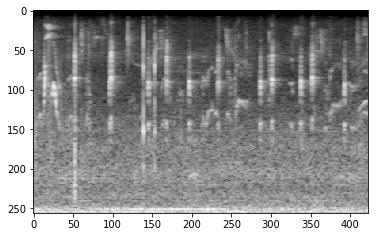

In [17]:
N = 3
sample_audio = X.detach().cpu().numpy()[N]
sample_spectrogram = spec.detach().cpu().numpy()[N, :,:]
plt.imshow(np.flipud(sample_spectrogram), cmap='gray')
print(sample_audio.std())
print(y[N])
ipd.Audio(sample_audio.reshape(-1), rate=sr)

In [18]:
spec.max(), spec.min()

(tensor(1.0493, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.0493, device='cuda:0', grad_fn=<MinBackward1>))

In [19]:
from birds_utils import validate, multilabel_metrics, get_F1_micro

In [20]:
import time
from datetime import timedelta

In [21]:
def train_model(model, dataset, validation_generator, criterion, name, metrics_func=multilabel_metrics, epochs=1, best_metric = 0):
    model.train()
    batches_per_epoch = len(dataset)
    losses = []
    F1s = []
    val_losses = []
    val_F1s = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        TPs = 0
        FPs = 0
        FNs = 0
        total_predictions = 0
        T_totals = 0
        model.train()
        start_time = time.time()
        for i, (X, y) in enumerate(dataset):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = X.to(device), y.to(device)
            # (1) Initialise gradients
            optimizer.zero_grad()
            # (2) Forward pass
            _, y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            running_loss = running_loss + loss
            # (3) Backward
            loss.backward()
            # (4) Compute the loss and update the weights
            optimizer.step()
            TP, FP, FN, micro_F1, total, T_total = metrics_func(y_pred, labels)
            TPs = TPs + TP.sum()
            FPs = FPs + FP.sum()
            FNs = FNs + FN.sum()
            total_predictions = total_predictions + total
            T_totals = T_totals + T_total
            
            avg_loss = running_loss/(i+1)
            avg_F1 = get_F1_micro(TPs, FPs, FNs)
            avg_acc = TPs/T_totals
            print(f'\r{epoch+1}/{epochs} - {i+1}/{batches_per_epoch} - loss: {avg_loss}, F1 micro: {avg_F1}, acc: {avg_acc}', end=', ')
        elapesed_time = (time.time() - start_time)
        print(f'elapesed_time: {timedelta(seconds=elapesed_time)}')
        losses.append(avg_loss)
        F1s.append(avg_F1)
        avg_loss, avg_F1, avg_acc = validate(model, validation_generator, criterion, device, metrics_func=multilabel_metrics)
        val_losses.append(avg_loss)
        val_F1s.append(avg_F1)
        if avg_F1>best_metric:
            best_metric = avg_F1
            print()
            print('Best model saved')
            torch.save(model.state_dict(), f'{name}_{int(best_metric*1000 + 0.5)/1000}.pth')
        else:
            print()
        print('--------------------------------------------------------------------------')
    return epoch+1, losses, F1s, val_losses, val_F1s

In [22]:
from birds_utils import FakeDataset

In [35]:
len(list(train_files))

17067

In [23]:
params_train = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 0}

params_val = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 0,
              'timeout': 0
             }
# classes = np.unique(train_labels)

N = 2

training_set = Dataset(list(train_files)*N, classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, 
                       add_noise=True, add_ambient_noise=True)
validation_set = Dataset(list(val_files)*N*2, classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, 
                         add_noise=False, add_ambient_noise=False)
training_generator = torch.utils.data.DataLoader(training_set, **params_train)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)


# training_set = FakeDataset(list(train_files[:1024])*N, n_classes, duration, sr)
# validation_set = FakeDataset(list(val_files[:1024])*N, n_classes, duration, sr)


# from birds_utils import DatasetSequence
# training_generator = DatasetSequence(list(train_files)*2, classes, batch_size=32, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=True, add_ambient_noise=True)
# validation_generator = DatasetSequence(list(train_files), classes, batch_size=32, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=False, add_ambient_noise=False)

In [24]:
# avg_loss, avg_F1, avg_acc = validate(model, validation_generator, criterion, device, metrics_func=multilabel_metrics)

In [25]:
LEARNING_RATE = 0.001
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# state_dict = torch.load('model_6_0.8288726210594177.pth', map_location=torch.device('cuda'))
# model.load_state_dict(state_dict)

In [26]:
# avg_loss, avg_F1, avg_acc = validate(model, validation_generator, criterion, device, metrics_func=multilabel_metrics)

# Estadísticas Resnet-18:

submit: 54.9 (model_ambient_librosa_264_0.677)
submit: 48.8 (model_ambient_librosa_264_0.73)

Adam(lr=0.001) epochs: 30 train f1: 0.9097, best_val_f1: 0.6886
Adam(lr=0.0001) epochs: 30-35 train f1: 0.9590, best_val_f1: 0.73


In [27]:
LEARNING_RATE = 0.001
for param_group in optimizer.param_groups:
        param_group['lr'] = LEARNING_RATE

In [28]:
epochs, losses, F1s, val_losses, val_F1s = train_model(model, training_generator, validation_generator, criterion, f'./models/model_mel_{n_classes}', 
            epochs=25, metrics_func=multilabel_metrics, best_metric=0.4)

1/25 - 1067/1067 - loss: 0.02495669573545456, F1 micro: 0.001294565387070179, acc: 0.0007751216762699187, elapesed_time: 0:29:20.429238
1069/1069 - val loss: 0.021310215815901756, val F1 micro: 0.0026964088901877403 val acc: 0.0013590314192697406
--------------------------------------------------------------------------
2/25 - 1067/1067 - loss: 0.01961967721581459, F1 micro: 0.013832607306540012, acc: 0.007038977928459644, elapesed_time: 0:29:38.486477
1069/1069 - val loss: 0.019188694655895233, val F1 micro: 0.06613915413618088 val acc: 0.037435136735439395
--------------------------------------------------------------------------
3/25 - 1067/1067 - loss: 0.017353560775518417, F1 micro: 0.07242855429649353, acc: 0.038815688341856, elapesed_time: 0:30:13.550374
1069/1069 - val loss: 0.016745641827583313, val F1 micro: 0.17043356597423553 val acc: 0.10551025718450546
--------------------------------------------------------------------------
4/25 - 1067/1067 - loss: 0.015804782509803772,

In [32]:
train_model_filename = f'./models/librosa_model_train_state_mel_{n_classes}_{epochs}.pth'
print(train_model_filename)

./models/librosa_model_train_state_mel_264_25.pth


In [33]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, train_model_filename)

In [29]:
# validation_set = Dataset(list(val_files), classes, std_stats, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, 
#                          add_noise=False, add_ambient_noise=False)
# validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)

# avg_loss, avg_F1, avg_acc = validate(model, validation_generator, criterion, device, metrics_func=multilabel_metrics)
# validation_set.stats

In [65]:
print(training_set.stats)
print(validation_set.stats)

{'noise': 1876, 'noise+signal': 16144, 'signal': 32258, 'passband_noise': 16343, 'short_file': 1756}
{'noise': 819, 'noise+signal': 0, 'signal': 14588, 'passband_noise': 0, 'short_file': 819}


In [34]:
# Cambiar acc!!!

In [ ]:
##### 14/20 - 340/340 - loss: 0.012936275452375412, F1 micro: 0.9772475361824036, acc: 0.9713182449340825
# 83/83 - val loss: 0.11272670328617096, val F1 micro: 0.8410007953643799 val acc: 0.7876039147377014
# Best model saved

In [21]:
torch.save(model.state_dict(), 'model_last_ml_std_auto_0.8750.pth')

In [33]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
X_img = torch.from_numpy(np.random.rand(2, 1, 44100)).float()